# 時間序列資料學習

氣溫、股票指數、音訊等隨時間變化的資料，都是時間序列資料。對於時間序列資料，也可以用機器學習技術處理，例如:
+ 分類問題: 給一段時間序列資料，分辨它是屬於哪一類。
+ 預測問題: 給一段時間序列資料，請問接下來若干時間點，最可能的值是甚麼。

相關技術也可以應用於有前後順序性的序列資料，如文件、自然語言等。這個單元，討論時間序列資料預測問題。

(回顧)以張量安排時間序列資料，通常安排成下面方式:
<table>
    <tr><th style="text-align:center">實例</th><th style="text-align:center">樣本張量結構(shape)</th><th style="text-align:center">樣本集張量結構(shape)</th></tr>
    <tr><td style="text-align:left">樣本可用向量表示</td><td style="text-align:left">(features,)</td><td style="text-align:left">(samples,features)</td></tr>
    <tr><td style="text-align:left" ><font color='red'>(時間)序列樣本</font></td><td style="text-align:left"><font color='red'>(timesteps,features)</font></td><td style="text-align:left"><font color='red'>(samples,timesteps,features)</font></td></tr>
    <tr><td style="text-align:left">影像樣本(channel last)</td><td style="text-align:left">(height,width,channel)</td><td style="text-align:left">(samples,height,width,channel)</td></tr>
    <tr><td style="text-align:left">影像樣本(channel first)</td><td style="text-align:left">(channel,height,width)</td><td style="text-align:left">(samples,channel,height,width)</td></tr>
    <tr><td style="text-align:left">視訊樣本(channel last)</td><td style="text-align:left">(frames,height,width,channel)</td><td style="text-align:left">(samples,frames,height,width,channel)</td></tr>
    <tr><td style="text-align:left">視訊樣本(channel first)</td><td style="text-align:left">(frames,channel,height,width)</td><td style="text-align:left">(samples,frames,channel,height,width)</td></tr>
</table>

舉例，若要根據過去10個時間點資料來預測未來某個時間點目標屬性的值(例如，水溫)，假如每個時間點只有一個觀測值(例如，水溫)，那麼每一個樣本其張量結構為(10,1)。若每個時間點有3個觀測值(例如，水溫、鹽度、流速)，那麼每一個樣本其張量結構為(10,3)。

下面先用合成時間序列資料、然後再用氣溫資料集來了解整個步驟與不同的模型設計方式。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


## 顯示時間序列資料的函式
以圖顯示時間序列資料，有助於理解資料在時間變化的趨勢。

In [2]:
def plot_series(series, time_index=None, ax = None, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$",xticks_num=10):
    plt.plot(series, ".-")
    extend_hl = 0
    
    if ax is None:
        ax = plt
        
    if y is not None:
        if hasattr(y,'size'):
            extend_hl = max(extend_hl,y.size)
            n_steps = np.arange(y.size)+series.size
        elif isinstance(y,tf.Tensor):
            extend_hl = max(extend_hl,y.numpy().size)
            n_steps = np.arange(y.numpy().size)+series.size

        plt.plot([series.size-1,series.size],[series[-1],y[0]],'.-b')
        plt.plot(n_steps, y, "-bx", markersize=10,label='true')
        
    if y_pred is not None:
        if hasattr(y_pred,'size'):
            extend_hl = max(extend_hl,y_pred.size)
            n_steps = np.arange(y_pred.size)+series.size
        elif isinstance(y_pred,tf.Tensor):
            extend_hl = max(extend_hl,y_pred.numpy().size)     
            n_steps = np.arange(y_pred.numpy().size)+series.size
        plt.plot([series.size-1,series.size],[series[-1],y_pred[0]],'.-r')
        plt.plot(n_steps, y_pred, "-ro",label='pred')
        
    plt.grid(True)
    
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
        
    if time_index is not None:
        plt.xticks(np.linspace(0,time_index.size-1,xticks_num),['{:.02f}'.format(x) for x in np.linspace(0,time_index[-1],xticks_num)])
        plt.axis([0, time_index.size-1, -1, 1])
        
    plt.hlines(0, 0, series.size+extend_hl, linewidth=1)
    
    if y is not None or y_pred is not None:
        plt.legend()

## 範例1:使用合成時間序列資料

### 產生合成時間序列資料
假設一個sine形狀的循環訊號$sin(t)$，$t$表示時間(秒)，我們在15秒內等時間間隔取樣100點，那麼會是下面的樣子。題外話，若等時間間隔取樣5點，那會是甚麼樣子呢?

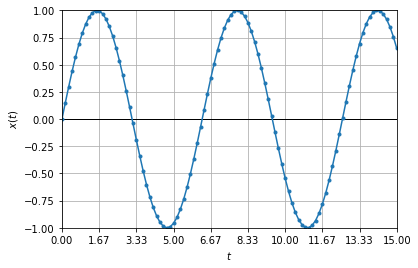

In [3]:
n_steps    = 100
time_index = np.linspace(0,15,n_steps)
x          = np.sin(time_index)
plt.figure()
plot_series(x,time_index)
plt.show()

假設一個sine形狀的循環的訊號$sin(t+10)$，$t$表示時間(秒)，我們在0\~1秒等時間間隔取樣100點，那麼其實就是$sin(t)$在10\~11秒取樣100點的樣子。

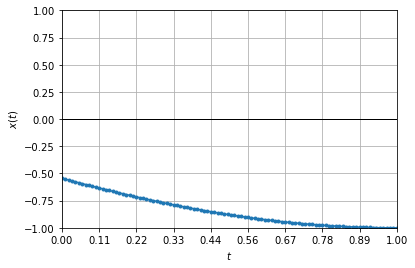

In [4]:
n_steps    = 100
time_index = np.linspace(0,1,n_steps)
x          = np.sin(time_index+10)
plt.figure()
plot_series(x,time_index)
plt.show()

假設一個sine形狀的循環的訊號$0.5sin(10(t+10))$，$t$表示時間(秒)，我們在一秒內取樣100點，那麼會是下面的樣子。可以知道$a\times sin(b(t+c))$，$a,b,c$分別會影響訊號的震幅、週期、時間軸平移。

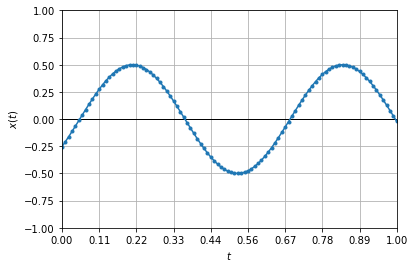

In [5]:
n_steps    = 100
time_index = np.linspace(0,1,n_steps)
x          = 0.5*np.sin(10*(time_index+10))
plt.figure()
plot_series(x,time_index)
plt.show()

將$0.5sin(10(t+10))$與$0.25sin(20(t+20))$相加後產生另一種波形。

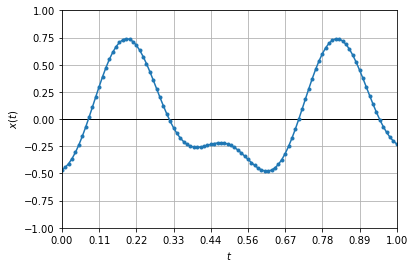

In [6]:
n_steps    = 100
time_index = np.linspace(0,1,n_steps)
x          = 0.5*np.sin(10*(time_index+10))+0.25*np.sin(20*(time_index+20))
plt.figure()
plot_series(x,time_index)
plt.show()

通常觀察到的訊號會含有雜訊。若此雜訊為高斯雜訊$G(0.2,0.1)$以"加減"形式混入訊號裡，那麼可以用下面方式模擬，其中np.random.rand產生高斯雜訊$G(0,1)$。

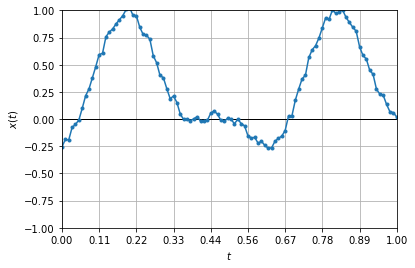

In [7]:
n_steps    = 100
time_index = np.linspace(0,1,n_steps)
x          = 0.5*np.sin(10*(time_index+10))+0.25*np.sin(20*(time_index+20))+ (0.1 *np.random.rand(n_steps) + 0.2)
plt.figure()
plot_series(x,time_index)
plt.show()

在每產生一個樣本(含多個時間點)時，隨機改變$0.5sin(10(t+10))$與$0.25sin(20(t+20))$的週期與在時間軸位移、然後疊加、再加上高斯雜訊。如下方式產生時間序列資料樣本。(下面函式應用了張量擴張計算技巧。)

In [8]:
def generate_samples(samples, n_steps):
    np.random.seed(9999) # 為了讓每次實驗以一樣的亂數seed產生資料
    freq1,freq2,offset1,offset2 = np.random.randn(4,samples,1)
    time_index = np.reshape(np.linspace(0,1,n_steps),(1,-1))
    x          = 0.5*np.sin((10+10*freq1)*(time_index+offset1+10))+\
                 0.25*np.sin((20+20*freq2)*(time_index+offset2+20))+\
                 (0.1 * np.random.rand(samples,n_steps) + 0.2)
    return x[..., np.newaxis].astype(np.float32)

顯示4個樣本，每個樣本含100時間點。可以看到，那4個樣本差距還蠻顯著的。

samples.shape =  (4, 100, 1)


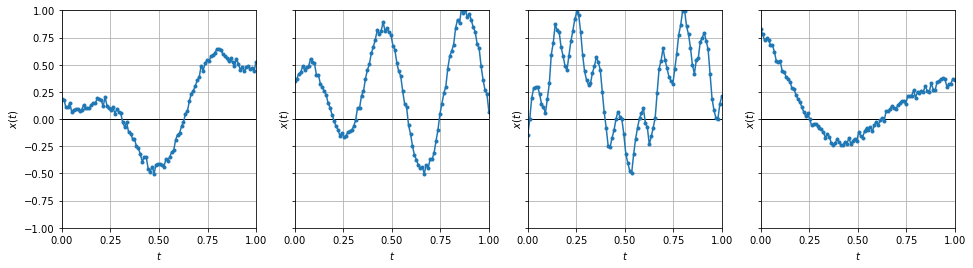

In [9]:
samples = generate_samples(4,100)
print('samples.shape = ',samples.shape)

fig,axes = plt.subplots(1,4,sharey=True,figsize=(16,4),squeeze=True)
for idx,ax in enumerate(axes):
    plt.sca(ax)
    freq1,freq2,offset1,offset2 = np.random.randn(4)
    time_index = np.linspace(0,1,n_steps)
    plot_series(samples[idx],time_index,xticks_num=5)
plt.show()

### 預測未來一個時間點的值

接下來我們打算用連續50個時間點資料來預測下個時間點的值。

#### 評估指標
+ mean squared error (MSE) = $\frac{1}{n}\sum_{i=1}^{n}(y\_true_{i}-y\_pred_{i})^{2}$
  + tf.keras.losses.MSE(y_true, y_pred)
+ mean absolute error (MAE) = $\frac{1}{n}\sum_{i=1}^{n}|y\_true_{i}-y\_pred_{i}|$
  + tf.keras.losses.MAE(y_true, y_pred)

#### 準備訓練、驗證、測試樣本

In [10]:
n_steps = 50
samples = generate_samples(10000,n_steps+1)
X_train = samples[:7000,:n_steps]
y_train = samples[:7000,-1]
X_valid = samples[7000:9000,:n_steps]
y_valid = samples[7000:9000,-1]
X_test  = samples[9000:,:n_steps]
y_test  = samples[9000:,-1]

print(samples.shape,X_train.shape,y_train.shape)

(10000, 51, 1) (7000, 50, 1) (7000, 1)


#### 建立預測函數
會嘗試下面幾個預測函數
1. The last value
2. Mean
3. Linear regression
4. Neural Network with one Dense layer
5. Neural Network with one SimpleRNN layer
6. Neural Network with three SimpleRNN layers 
7. Neural Network with three SimpleRNN layers and one dense layer

#### 預測函數1:用前一時刻的值當作預測值
$y_{i}=x_{i50}$

<font color="red">預測函數1簡單而且可以成為評估其他方法的基準。</font>

MSE: 0.020201461


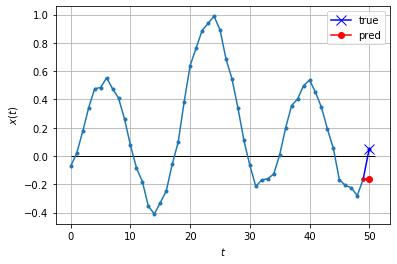

In [11]:
y_pred_1 = X_test[:,-1]
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_1)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_1[0])

#### 預測函數2:用平均值來預測下一時刻
$y_{i} = \frac{1}{50}\sum_{j=1}^{50}x_{ij}$

MSE: 0.15167175


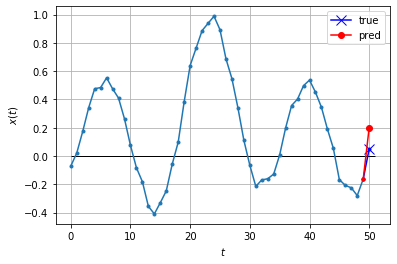

In [12]:
y_pred_2 = tf.reduce_mean(X_test,axis=1)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_2)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_2[0])

#### 預測函數3:線性迴歸
$y_{i}=a_{1}x_{i1}+...+a_{50}x_{i50}+b\Rightarrow y_{i}=\begin{bmatrix}x_{i1},...,x_{i50},1\end{bmatrix}\begin{bmatrix} a_{1} \\ ... \\ a_{50} \\ b \end{bmatrix}\Rightarrow\mathbf{y}=\mathbf{X}\mathbf{a}$

MSE 0.008406538411198948


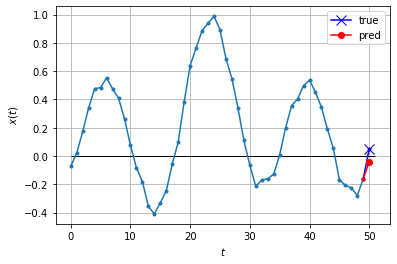

In [13]:
X = np.hstack([np.reshape(X_train,(-1,50)), np.ones((X_train.shape[0],1))])
a = np.linalg.lstsq(X, y_train.ravel(), rcond=None)[0]
y_pred_3 = np.dot(np.hstack([np.reshape(X_test,(-1,50)), np.ones((X_test.shape[0],1))]),np.reshape(a,(-1,1)))
print('MSE',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_3)).numpy())                

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_3[0])

#### 預測函數4:一層全連接層的類神經網路

In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(50,1)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 160us/sample - loss: 0.2799 - val_loss: 0.1210
Epoch 2/20
7000/7000 [==============================] - 0s 56us/sample - loss: 0.0863 - val_loss: 0.0587
Epoch 3/20
7000/7000 [==============================] - 0s 56us/sample - loss: 0.0521 - val_loss: 0.0428
Epoch 4/20
7000/7000 [==============================] - 0s 56us/sample - loss: 0.0399 - val_loss: 0.0349
Epoch 5/20
7000/7000 [==============================] - 0s 57us/sample - loss: 0.0331 - val_loss: 0.0292
Epoch 6/20
7000/7000 [==============================] - 0s 57us/sample - loss: 0.0284 - val_loss: 0.0252
Epoch 7/20
7000/7000 [==============================] - 0s 56us/sample - loss: 0.0251 - val_loss: 0.0230
Epoch 8/20
7000/7000 [==============================] - 0s 58us/sample - loss: 0.0225 - val_loss: 0.0203
Epoch 9/20
7000/7000 [==============================] - 0s 59us/sample - loss: 0.0205 - val_loss: 0.0186
Epoch 

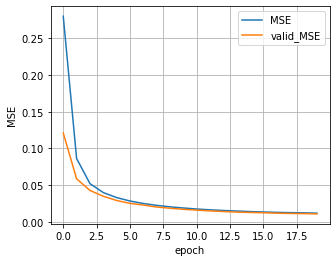

In [15]:
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE 0.011074635


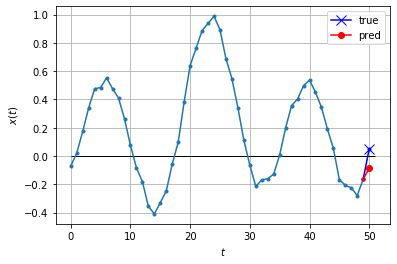

In [16]:
y_pred_4 = model.predict(X_test)
print('MSE',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_4)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_4[0])

#### 預測函數5:簡單RNN
下面顯示一個簡單的遞迴類神經單元，他會將上一個時刻的輸出$\mathbf{y}_{t-1}$匯回與這個時刻的輸入$\mathbf{x}_{t}$一起當作輸入。
<div>
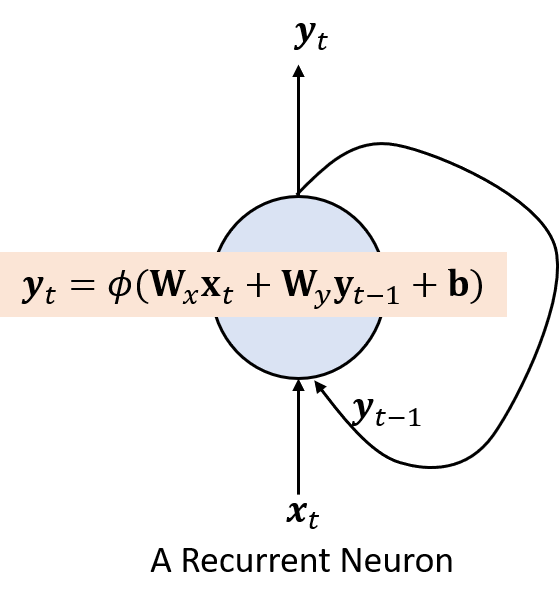
</div>    
注意SimpleRNN的觸發函數預設為tanh。若要嘗試GRU或LSTM，可置換SimpleRNN。

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 683us/sample - loss: 0.1257 - val_loss: 0.0968
Epoch 2/20
7000/7000 [==============================] - 4s 557us/sample - loss: 0.0821 - val_loss: 0.0687
Epoch 3/20
7000/7000 [==============================] - 4s 559us/sample - loss: 0.0616 - val_loss: 0.0520
Epoch 4/20
7000/7000 [==============================] - 4s 557us/sample - loss: 0.0467 - val_loss: 0.0388
Epoch 5/20
7000/7000 [==============================] - 4s 572us/sample - loss: 0.0345 - val_loss: 0.0284
Epoch 6/20
7000/7000 [==============================] - 4s 573us/sample - loss: 0.0256 - val_loss: 0.0213
Epoch 7/20
7000/7000 [==============================] - 4s 575us/sample - loss: 0.0199 - val_loss: 0.0172
Epoch 8/20
7000/7000 [==============================] - 4s 571us/sample - loss: 0.0170 - val_loss: 0.0153
Epoch 9/20
7000/7000 [==============================] - 4s 569us/sample - loss: 0.0157 - val_loss: 0.014

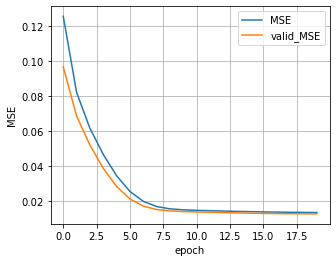

In [17]:
srnn_model = tf.keras.models.Sequential()
srnn_model.add(tf.keras.layers.SimpleRNN(1, input_shape =[ None, 1]) )
srnn_model.compile(loss="mse", optimizer="adam")
history = srnn_model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE: 0.012793909


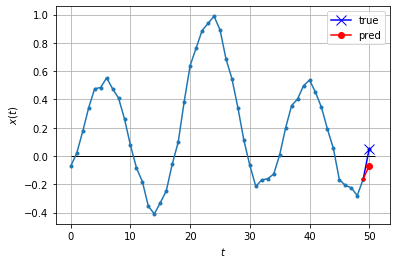

In [18]:
y_pred_5 = srnn_model.predict(X_test)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_5)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_5[0])

#### 預測函數6:多堆疊幾層SimpleRNN
+ 下面前兩個SimpleRNN之return_sequences要設成True，以便每個時間點的輸出都會給下一層，不然只會有最後一個時間點的輸出。舉例，若輸入是50個時間點，那麼下面的輸出shape會是(50,20)。若return_sequences設成False，那麼輸出為(20,)


         tf.keras.layers.SimpleRNN(20, return_sequences=True)
         
         

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0562 - val_loss: 0.0157
Epoch 2/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0135 - val_loss: 0.0102
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0106 - val_loss: 0.0092
Epoch 4/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0101 - val_loss: 0.0093
Epoch 5/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0099 - val_loss: 0.0088
Epoch 6/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0097 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0096 - val_loss: 0.0086
Epoch 8/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0096 - val_loss: 0.0085
Epoch 9/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0095 - val_loss: 0.0085
Epoch 1

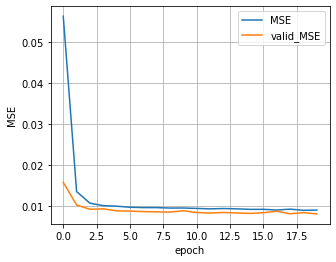

In [19]:
drnn_model = tf.keras.models.Sequential()
drnn_model.add(tf.keras.layers.SimpleRNN(15, return_sequences=True, input_shape =[ None, 1]) )
drnn_model.add(tf.keras.layers.SimpleRNN(15, return_sequences=True) )
drnn_model.add(tf.keras.layers.SimpleRNN(1) )
drnn_model.compile(loss="mse", optimizer="adam")
history = drnn_model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE: 0.008141725


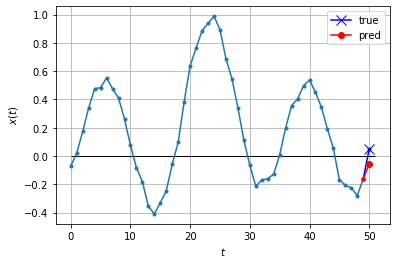

In [20]:
y_pred_6 = drnn_model.predict(X_test)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_6)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_6[0])

由於drnn_model沒限制每一段序列長度。我們來比較看看，50時間點、40時間點、30時間點、20時間點、10時間點的預測準確度。看來約最近的30時間點來預測就夠了。

In [21]:
for n_steps in [50,40,30,20,10]:
    y_p = drnn_model.predict(X_train[:,50-n_steps:])
    tr_mse = tf.reduce_mean(tf.keras.losses.MSE(y_train, y_p)).numpy()
    y_p = drnn_model.predict(X_test[:,50-n_steps:])
    te_mse = tf.reduce_mean(tf.keras.losses.MSE(y_test, y_p)).numpy()
    print('MSE (n_steps:{}):train {:.4f} test {:.4f}'.format(n_steps,tr_mse,te_mse))

MSE (n_steps:50):train 0.0086 test 0.0081
MSE (n_steps:40):train 0.0086 test 0.0081
MSE (n_steps:30):train 0.0086 test 0.0082
MSE (n_steps:20):train 0.0087 test 0.0083
MSE (n_steps:10):train 0.0120 test 0.0118


#### 預測函數7:改變一下輸出層為全連接層。 

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0371 - val_loss: 0.0145
Epoch 2/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0129 - val_loss: 0.0104
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0103 - val_loss: 0.0098
Epoch 4/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0096 - val_loss: 0.0087
Epoch 5/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0093 - val_loss: 0.0084
Epoch 6/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0090 - val_loss: 0.0078
Epoch 7/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0086 - val_loss: 0.0085
Epoch 8/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0086 - val_loss: 0.0076
Epoch 9/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0083 - val_loss: 0.0077
Epoch 1

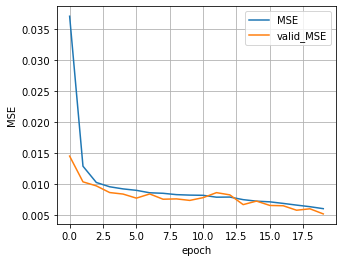

In [22]:
drnn_model2 = tf.keras.models.Sequential()
drnn_model2.add(tf.keras.layers.SimpleRNN(15, return_sequences=True, input_shape =[None, 1]) )
drnn_model2.add(tf.keras.layers.SimpleRNN(15, return_sequences=True) )
drnn_model2.add(tf.keras.layers.SimpleRNN(15))
drnn_model2.add(tf.keras.layers.Dense(1) )
drnn_model2.compile(loss="mse", optimizer="adam")
history = drnn_model2.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE: 0.0053715147


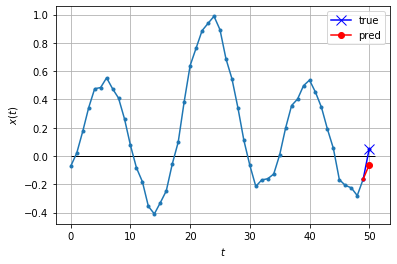

In [23]:
y_pred_7 = drnn_model2.predict(X_test)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_7)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_7[0])

#### 比較7個預測函數

In [24]:
for y_p,name in [(y_pred_1,'The last value'),(y_pred_2,'Average'),(y_pred_3,'Linear Regression'),(y_pred_4,'Dense'),(y_pred_5,'SimpleRNN'),\
 (y_pred_6,'RNN/RNN/RNN'),(y_pred_7,'RNN/RNN/RNN/Dense')]:
    print('Method:{:<25s} MSE:{:.3f}'.format(name,tf.reduce_mean(tf.keras.losses.MSE(y_test, y_p)).numpy()))

Method:The last value            MSE:0.020
Method:Average                   MSE:0.152
Method:Linear Regression         MSE:0.008
Method:Dense                     MSE:0.011
Method:SimpleRNN                 MSE:0.013
Method:RNN/RNN/RNN               MSE:0.008
Method:RNN/RNN/RNN/Dense         MSE:0.005


### 預測多個時間點
假設往前預測5個時間點的值。
+ 方法1:在不修改上面模型的狀況下，可以將預測的下個時間點當作資料，與原本資料串接後，用來預測下下個時刻。以此類推可以往前預測多個時間點。
<div>
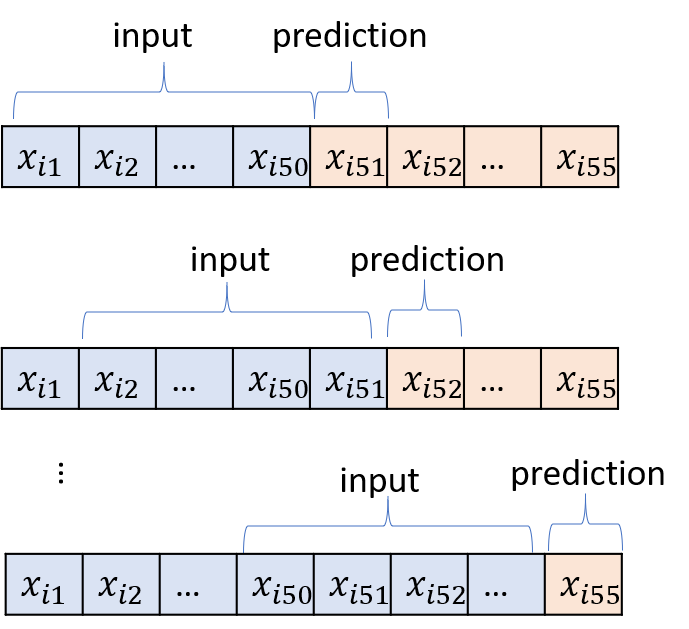
</div>
+ 方法2:直接擴充輸出層輸出單元數，訓練一次可以預測多個未來時間點的模型。
<div>
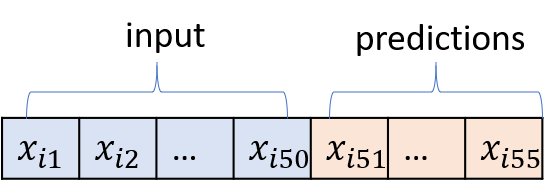
</div>
+ 方法3:建立遞迴類神經網路，訓練他在第$x_{i1}$時間點輸出$x_{i2},...,x_{i6}$,在第二時間點$x_{i2}$輸出$x_{i3},...,x_{i7}$，...,在第50時間點輸出$x_{i51},...,x_{i55}$。對一個測試序列，取最後一時間點的輸出為預測結果。
<div>
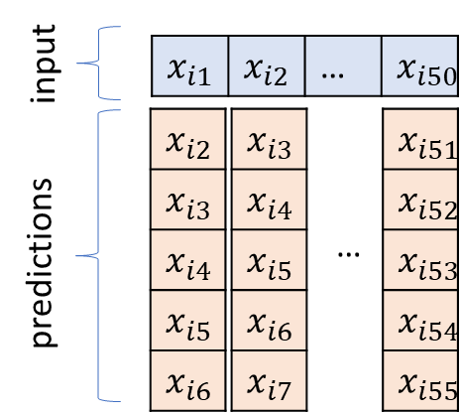
</div>

下面例子先示範用方法1往前預測5點。

#### 方法1

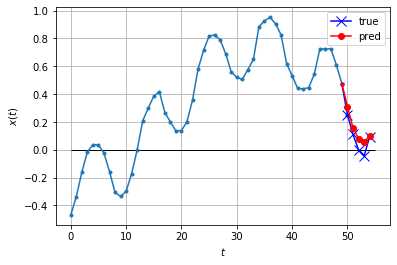

In [25]:
n_steps    = 50
new_sample = generate_samples(1,n_steps+5)
X_new      = new_sample[:,:n_steps]
for _ in range(1,6):
    y_pred = drnn_model2.predict(X_new)
    X_new  = np.concatenate([X_new[:,1:], y_pred[:,:,np.newaxis]],axis=1)
plot_series(new_sample[0,:n_steps],y=new_sample[0,n_steps:],y_pred=X_new[0,-5:])                            

#### 方法2
準備訓練資料。

In [26]:
n_steps = 50
samples2 = generate_samples(10000,n_steps+5)
X_train2 = samples2[:7000,:n_steps]
y_train2 = samples2[:7000,n_steps:,0]
X_valid2 = samples2[7000:9000,:n_steps]
y_valid2 = samples2[7000:9000,n_steps:,0]
X_test2  = samples2[9000:,:n_steps]
y_test2  = samples2[9000:,n_steps:,0]

In [27]:
print(samples[:7000,n_steps:,0].shape)

(7000, 1)


Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.1568 - val_loss: 0.0963
Epoch 2/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0852 - val_loss: 0.0750
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0721 - val_loss: 0.0652
Epoch 4/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0677 - val_loss: 0.0620
Epoch 5/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0667 - val_loss: 0.0613
Epoch 6/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0659 - val_loss: 0.0604
Epoch 7/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0652 - val_loss: 0.0589
Epoch 8/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0639 - val_loss: 0.0582
Epoch 9/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0619 - val_loss: 0.0549
Epoch 1

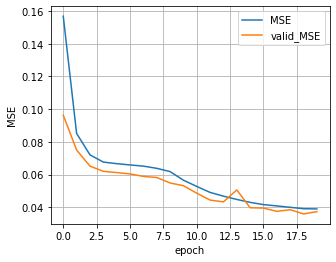

In [28]:
drnn_model3 = tf.keras.models.Sequential()
drnn_model3.add(tf.keras.layers.SimpleRNN(15, return_sequences=True, input_shape =[None, 1]) )
drnn_model3.add(tf.keras.layers.SimpleRNN(15, return_sequences=True) )
drnn_model3.add(tf.keras.layers.SimpleRNN(15))
drnn_model3.add(tf.keras.layers.Dense(5) )
drnn_model3.compile(loss="mse", optimizer="adam")
history = drnn_model3.fit(X_train2, y_train2, epochs=20,validation_data=(X_valid2, y_valid2))

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE: 0.040895537


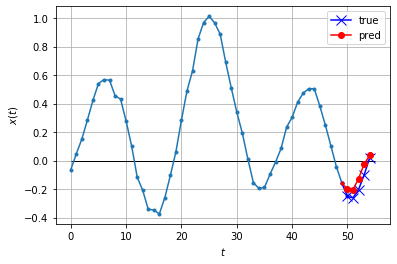

In [29]:
y_pred_mpt_2 = drnn_model3.predict(X_test2)
plot_series(X_test2[0],y=y_test2[0],y_pred=y_pred_mpt_2[0])  
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test2, y_pred_mpt_2)).numpy())

#### 方法3
準備訓練資料。

In [30]:
n_steps  = 50
samples3 = generate_samples(10000, n_steps + 5)
X_train3 = samples3[:7000, :n_steps]
X_valid3 = samples3[7000:9000, :n_steps]
X_test3  = samples3[9000:, :n_steps]
y        = np.empty((10000, n_steps, 5))
for step_ahead in range(1, 5 + 1):
    y[..., step_ahead - 1] = samples3[..., step_ahead:step_ahead + n_steps, 0]
y_train3 = y[:7000]
y_valid3 = y[7000:9000]
y_test3  = y[9000:]

In [31]:
mp_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(15, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(15, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5))
])
mp_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, None, 15)          255       
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, None, 15)          465       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 5)           80        
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________


In [32]:
def last_timestep_mse(y_true, y_pred):
    return tf.keras.metrics.mean_squared_error(y_true[:, -1], y_pred[:, -1])

mp_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=[last_timestep_mse])
history = mp_model.fit(X_train3, y_train3, epochs=20,validation_data=(X_valid3, y_valid3))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0737 - last_timestep_mse: 0.0709 - val_loss: 0.0625 - val_last_timestep_mse: 0.0553
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0590 - last_timestep_mse: 0.0539 - val_loss: 0.0542 - val_last_timestep_mse: 0.0465
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0499 - last_timestep_mse: 0.0430 - val_loss: 0.0420 - val_last_timestep_mse: 0.0326
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0413 - last_timestep_mse: 0.0328 - val_loss: 0.0376 - val_last_timestep_mse: 0.0291
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0371 - last_timestep_mse: 0.0283 - val_loss: 0.0333 - val_last_timestep_mse: 0.0242
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0346 - last_timestep_mse: 0.0254 - val_loss: 0.0321 

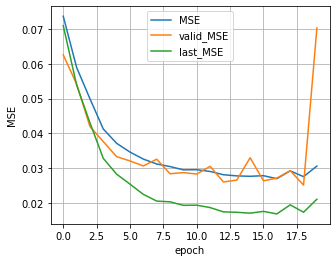

In [33]:
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.plot(history.history['last_timestep_mse'],label='last_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE: 0.07036219716249184


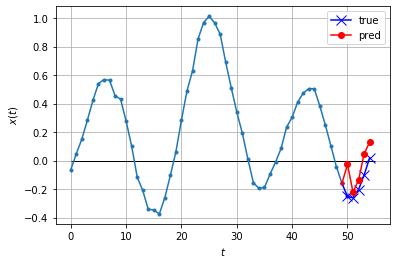

In [34]:
y_pred_mpt_3 = mp_model.predict(X_test3)[:,-1]
plot_series(X_test3[0],y=y_test3[0,-1],y_pred=y_pred_mpt_3[0])  
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_pred_mpt_3,y_test3[:,-1,:])).numpy())

## 天氣資料集
這個天氣資料集(<a href="https://www.bgc-jena.mpg.de/wetter/" target="_blank">資料來源</a>)包含從2003年起，每隔10分鐘紀錄如大氣溫度、壓力、濕度等14個天氣觀測值。在Tensorflow<a href="https://www.tensorflow.org/tutorials/structured_data/time_series" target="_blank">官方範例</a>及François Chollet的<a href="https://www.manning.com/books/deep-learning-with-python" target="_blank">書</a>裡都有使用這個資料集示範溫度預測。

#### 下載資料檔
2009~2016年紀錄。

In [35]:
zip_path = tf.keras.utils.get_file(
    origin='https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
filename = os.path.splitext(zip_path)[0]

In [36]:
df = pd.read_csv(filename)

每筆紀錄含時間戳記與14項觀測值。每筆紀錄間隔10分鐘。

In [37]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


C:\Users\superman\.conda\envs\tf-gpu\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


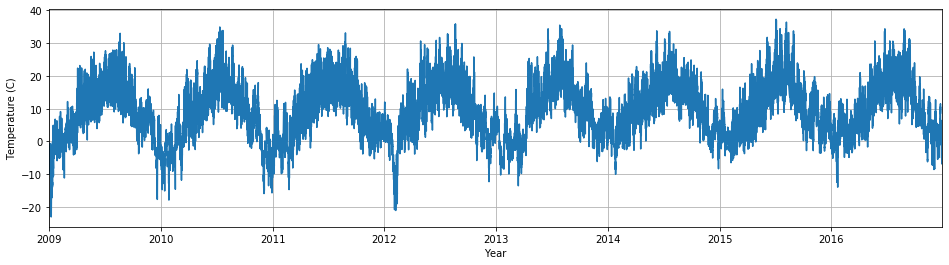

In [38]:
year_idx  = [np.argwhere(df['Date Time'] == '01.01.{} 00:10:00'.format(year)).ravel()[0] for year in range(2009,2017)]
year_label= [str(year) for year in range(2009,2017)]
temperature_df       = df['T (degC)']
temperature_df.index = df['Date Time']
ax = temperature_df.plot(xticks=year_idx,rot=0,figsize=(16,4))
ax.set_xticklabels(year_label)
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Year')
ax.grid(True)

顯示那幾年1月份氣溫變化。

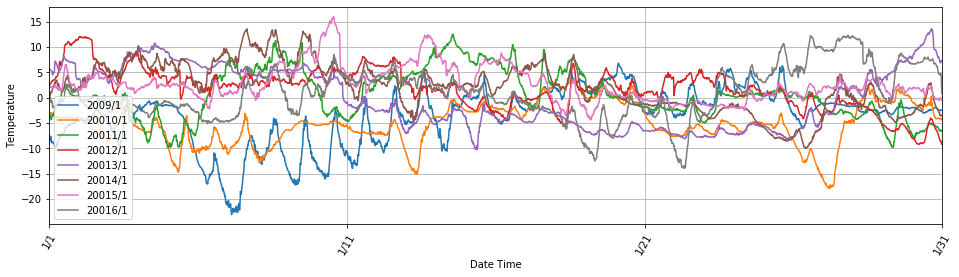

In [39]:
for y,year_start in enumerate(year_idx):
    ax = temperature_df[year_start:year_start+4320].plot(rot=60,figsize=(16,4),label='200{}/1'.format(y+9))
    ax.grid(True)
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Date Time')
ax.set_xticks([6*24*10*i for i in range(0,4)])
ax.set_xticklabels(['1/{}'.format(i*10+1) for i in range(0,4)])    
ax.legend();

若只想用過去溫度預測未來溫度，可以用下面指令取得溫度資料並轉成numpy array。

In [40]:
temperature_data = temperature_df.values
print(temperature_data.shape)

(420551,)


### 應用過去5天的氣壓(p)、氣溫(T)、大氣密度($\rho$)，來預測未來12小時氣溫變化
採用方法2做多時間點預測。

In [41]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [42]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


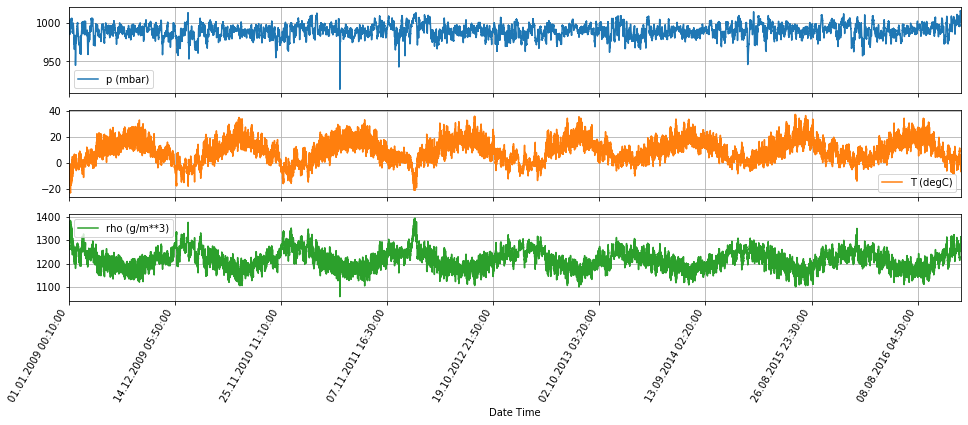

In [43]:
ax=features.plot(subplots=True,figsize=(16,6),rot=60)
for a in ax:
    a.grid(True)

In [44]:
dataset   = features.values

train_timesteps = 5*24*6
target_timesteps= 12*6
total_steps     = train_timesteps+target_timesteps
wind            = dataset.shape[0]//total_steps
train_dt  = dataset[:total_steps*(wind*3//4)]
valid_dt  = dataset[-total_steps*(wind-wind*3//4):]

train_mean = np.mean(train_dt,axis=0)
train_std  = np.std(train_dt,axis=0)
print(train_dt.shape,valid_dt.shape)

(314424, 3) (105336, 3)


#### 資料前處理
這三個觀測值的數值範圍差距很大，可以使用前處理方式，讓它們各自平均值與標準差變成0與1。

In [45]:
def Scalar(x,y):
    return (x[...,:] - train_mean)/train_std,(y-train_mean[1])/train_std[1]

In [46]:
BATCH_SIZE = 4
EPOCHS     = 30
steps      = 1
train_dt   = np.reshape(train_dt,(-1,total_steps,3))
valid_dt   = np.reshape(valid_dt,(-1,total_steps,3))

TRAIN_STEP_PER_EPOCH = train_dt.shape[0]//BATCH_SIZE
VALID_STEP_PER_EPOCH = valid_dt.shape[0]//BATCH_SIZE

X_train    = train_dt[:,:train_timesteps:steps,:]
y_train    = train_dt[:,train_timesteps:,1]
X_valid    = valid_dt[:,:train_timesteps:steps,:]
y_valid    = valid_dt[:,train_timesteps:,1]

train_ds   = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_ds   = train_ds.map(Scalar).cache().shuffle(1000).batch(BATCH_SIZE).repeat()
valid_ds   = tf.data.Dataset.from_tensor_slices((X_valid,y_valid))
valid_ds   = valid_ds.map(Scalar).batch(BATCH_SIZE).repeat()


#### 建立類神經網路架構
第一層使用AveragePooling1D的目的是將輸入每一小時有6個時間點，降成1個。接下來堆疊兩個LSTM，然後用全連接層輸出未來12小時溫度變化。

In [47]:
temperature_model = tf.keras.models.Sequential()
temperature_model.add(tf.keras.layers.AveragePooling1D(6,input_shape=[None,3]))
temperature_model.add(tf.keras.layers.LSTM(32,return_sequences=True))
temperature_model.add(tf.keras.layers.LSTM(72,dropout=0.2,recurrent_dropout=0.2))
temperature_model.add(tf.keras.layers.Dense(72))

temperature_model.compile(loss='mean_absolute_error', optimizer="adam")

In [48]:
history = temperature_model.fit(train_ds, epochs=EPOCHS,steps_per_epoch=TRAIN_STEP_PER_EPOCH,validation_data=valid_ds,validation_steps=VALID_STEP_PER_EPOCH)

Train for 99 steps, validate for 33 steps
Epoch 1/30
99/99 [==============================] - 19s 192ms/step - loss: 0.5426 - val_loss: 0.4184
Epoch 2/30
99/99 [==============================] - 13s 132ms/step - loss: 0.4234 - val_loss: 0.4181
Epoch 3/30
99/99 [==============================] - 13s 135ms/step - loss: 0.4078 - val_loss: 0.3979
Epoch 4/30
99/99 [==============================] - 13s 129ms/step - loss: 0.3861 - val_loss: 0.4169
Epoch 5/30
99/99 [==============================] - 13s 130ms/step - loss: 0.3717 - val_loss: 0.4026
Epoch 6/30
99/99 [==============================] - 13s 130ms/step - loss: 0.3627 - val_loss: 0.3664
Epoch 7/30
99/99 [==============================] - 13s 130ms/step - loss: 0.2953 - val_loss: 0.3253
Epoch 8/30
99/99 [==============================] - 13s 130ms/step - loss: 0.2651 - val_loss: 0.3201
Epoch 9/30
99/99 [==============================] - 13s 131ms/step - loss: 0.2509 - val_loss: 0.3065
Epoch 10/30
99/99 [==============================

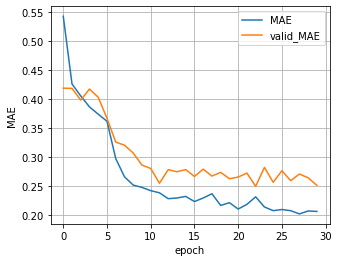

In [49]:
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MAE')
plt.plot(history.history['val_loss'],label='valid_MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MAE: 0.7246002626419068


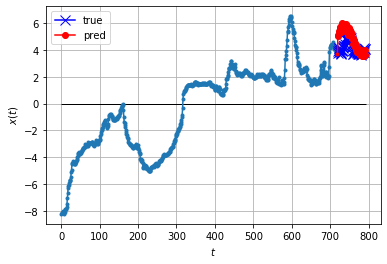

In [50]:
for x, y in valid_ds.take(1):
    y_pred = temperature_model.predict(x)[0]
    plot_series(x[0].numpy()[:,1]*train_std[1]+train_mean[1],y=y[0].numpy()*train_std[1]+train_mean[1],y_pred=y_pred*train_std[1]+train_mean[1])  
    print('MAE:',tf.reduce_mean(tf.keras.losses.MAE(y_pred*train_std[1]+train_mean[1],y[0]*train_std[1]+train_mean[1])).numpy())

In [ ]:
%%html
<style>
@media print {
    a[href]::after {
        content: none !important;
    }
}
</style>